### Train a Sentiment Classifier Using Annotated CrowdFlower Data
A Super Handy CrowdFlower Glossary of Terms can be found [here](https://success.crowdflower.com/hc/en-us/articles/202703305-Glossary-of-Terms)!

In [1]:
import re
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.cluster import MiniBatchKMeans

from nltk.tokenize.casual import TweetTokenizer
from nltk.stem import PorterStemmer

from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

pd.set_option("display.max_rows", 500)
pd.set_option('display.max_colwidth', -1)

warnings.filterwarnings("ignore", category=DeprecationWarning)

#### Read-In Jobs-Level Data (from CrowdFlower's *Data for Everyone* [library](https://www.crowdflower.com/data-for-everyone/))

In [2]:
in_file = "http://cdn2.hubspot.net/hub/346378/file-2612489700-csv/DFE_CSVs/Airline-Full-Non-Ag-DFE-Sentiment.csv"
variables = ["tweet_id","text","airline_sentiment","_trust"]

cf = pd.read_csv(in_file)[variables]
cf["airline_sentiment"].replace(["positive","neutral","negative"], [1,0,-1], inplace=True)

print cf.columns
print cf.airline_sentiment.value_counts()
cf.head(10)

Index([u'tweet_id', u'text', u'airline_sentiment', u'_trust'], dtype='object')
-1    36280
 0    11027
 1    8476 
Name: airline_sentiment, dtype: int64


,tweet_id,text,airline_sentiment,_trust
0,570306133677760513,@VirginAmerica What @dhepburn said.,0,0.8108
1,570306133677760513,@VirginAmerica What @dhepburn said.,0,0.8919
2,570306133677760513,@VirginAmerica What @dhepburn said.,0,0.7222
3,570301130888122368,@VirginAmerica plus you've added commercials to the experience... tacky.,1,0.8966
4,570301130888122368,@VirginAmerica plus you've added commercials to the experience... tacky.,0,0.8108
5,570301130888122368,@VirginAmerica plus you've added commercials to the experience... tacky.,-1,0.8649
6,570301083672813571,@VirginAmerica I didn't today... Must mean I need to take another trip!,1,0.8649
7,570301083672813571,@VirginAmerica I didn't today... Must mean I need to take another trip!,0,0.9459
8,570301083672813571,@VirginAmerica I didn't today... Must mean I need to take another trip!,0,0.9231
9,570301031407624196,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",-1,0.7297


#### Cluster as Positive /Neutral /Negative Tweets Based on Annotated Sentiments
Calculate Tweet Sentiment Score (average jugement weighted by trust score)

In [3]:
def scoreTweets(df):
    df2 = df.copy()
    df2["num"] = df2.airline_sentiment*df2._trust
    df2["denom"] = df2._trust
    
    df3 = df2.groupby(by=["tweet_id","text"], as_index=False)[["num","denom"]].mean()
    df3["sentScore"] = df3.num / df3.denom
    
    return df3[["tweet_id","text","sentScore"]]

In [4]:
cf_1 = scoreTweets(cf)
cf_1.head(5)

,tweet_id,text,sentScore
0,567588278875213824,@JetBlue's new CEO seeks the right balance to please passengers and Wall ... - Greenfield Daily Reporter http://t.co/LM3opxkxch,0
1,567590027375702016,@JetBlue is REALLY getting on my nerves !! 😡😡 #nothappy,-1
2,567591480085463040,@united yes. We waited in line for almost an hour to do so. Some passengers just left not wanting to wait past 1am.,-1
3,567592368451248130,"@united the we got into the gate at IAH on time and have given our seats and closed the flight. If you know people is arriving, have to wait",-1
4,567594449874587648,"@SouthwestAir its cool that my bags take a bit longer, dont give me baggage blue balls-turn the carousel on, tell me it's coming, then not.",-1


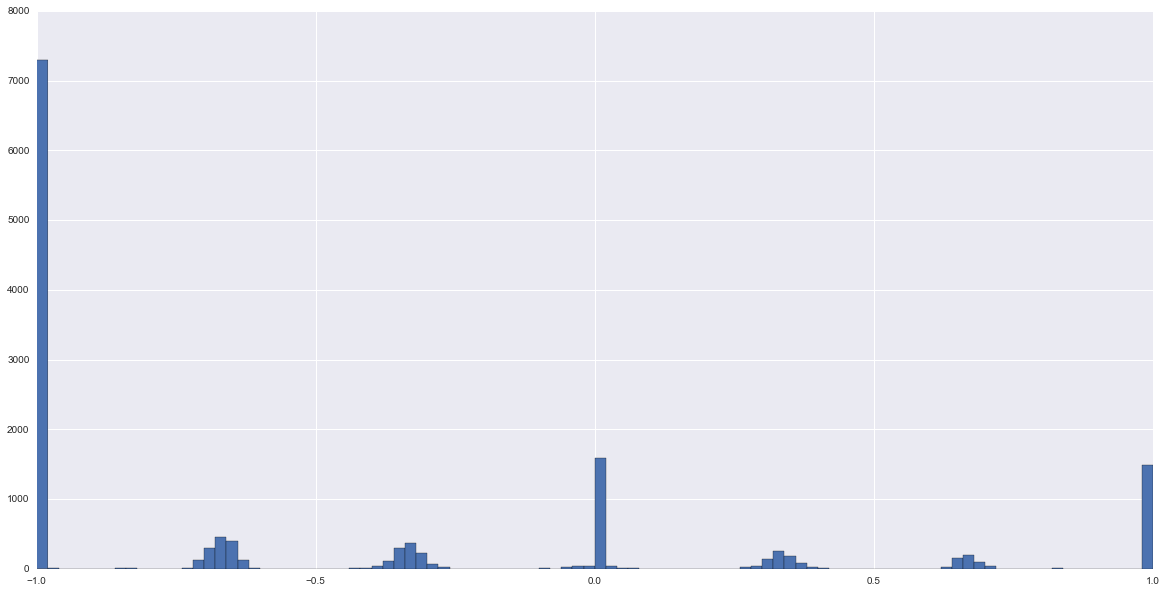

In [5]:
plt.figure(figsize=(20,10))
plt.hist(cf_1["sentScore"], bins=100); #semicolon suppresses array print :)

#### Cluster Tweets into Sentiment Categories by Score

In [6]:
def clusterTweets(df, n=5):
    kmeans = MiniBatchKMeans(n_clusters=n, random_state=4444)
    data = df.sentScore.reshape(-1, 1)
    clusters = pd.Series(kmeans.fit_predict(data), name="sentCluster")
    
    return pd.concat([df, clusters], axis=1)

In [7]:
cf_2 = clusterTweets(cf_1)
cf_2.head(5)

,tweet_id,text,sentScore,sentCluster
0,567588278875213824,@JetBlue's new CEO seeks the right balance to please passengers and Wall ... - Greenfield Daily Reporter http://t.co/LM3opxkxch,0,2
1,567590027375702016,@JetBlue is REALLY getting on my nerves !! 😡😡 #nothappy,-1,1
2,567591480085463040,@united yes. We waited in line for almost an hour to do so. Some passengers just left not wanting to wait past 1am.,-1,1
3,567592368451248130,"@united the we got into the gate at IAH on time and have given our seats and closed the flight. If you know people is arriving, have to wait",-1,1
4,567594449874587648,"@SouthwestAir its cool that my bags take a bit longer, dont give me baggage blue balls-turn the carousel on, tell me it's coming, then not.",-1,1


In [10]:
cf_2.groupby(by="sentCluster")["sentScore"].agg([min, max, np.mean])

,min,max,mean
sentCluster,,,
0,0.813460,1.000000,0.999147
1,-1.000000,-0.796934,-0.999535
2,-0.238344,0.187935,-0.000310
3,-0.757204,-0.261144,-0.519455
4,0.231046,0.726345,0.468047


In [11]:
cf_2["sentCluster"].replace([0, 1, 2, 3, 4], [1, -1, 0, -0.5, 0.5], inplace=True) 
#note - this might change if we add/ subtract clusters

print cf_2.sentCluster.value_counts()

-1.0    7323
-0.5    2595
 0.0    1781
 1.0    1497
 0.5    1289
Name: sentCluster, dtype: int64


#### Split Data into Train and Test

In [ ]:
cf_train, cf_test = train_test_split(cf_2, test_size=0.2, random_state=4444)

#### Feature Engineering

In [ ]:
def preprocesser(text):
    text = re.sub(r"(?:\https?\://)\S+", "", text) #remove urls
    text = re.sub('\@(\w+)', " ", text).replace(": ","") #remove usernames
    text = re.sub('#(\w+)', " ", text) #remove hashtags
    text = text.replace("RT ","") #remove RT Symbols
    text = text.replace("RT: ","") #remove RT Symbols
    text = re.sub("[^a-zA-Z,]+", " ", text) #remove other non-alpha characters
    text = text.strip(" ") #remove leading and trailing whitespace
    
    return text

def tokenizer(text):
    tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)    
    return [x for x in tokenizer.tokenize(preprocess(text)) if len(x)>=4]

#### Train Text Classifier & Hypertune Parameters